# 0. IMPORTACIONES Y CONFIGURACIÓN INICIAL

In [45]:
import pandas as pd
import numpy as np
import math
import random
import time
from collections import defaultdict

# Machine Learning y Recommender Systems
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense, Concatenate, Dot
from keras.optimizers import Adam

# Visualización (opcional, pero útil para el póster)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones
plt.style.use('seaborn-v0_8-whitegrid') # Estilo para los gráficos
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [5]:
pd.options.display.max_columns = False


# PREPROCESAMIENTO DEL DATASET DE ANIME


In [28]:
df_ratings = pd.read_csv('csv/rating.csv', encoding='utf8')
df_titles = pd.read_csv('csv/anime.csv', encoding='utf8')

In [29]:
df_ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [30]:
df_titles.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [31]:
print(f"Tamaño de ratings: {len(df_ratings)}")

Tamaño de ratings: 7813737


Vamos a mirar los ratings que hay a ver si hay algún valor inesperado.

In [32]:
print(f"Ratings distintos: {sorted(df_ratings.rating.unique())}")

Ratings distintos: [np.int64(-1), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


Hay ratings que son -1. Según la información oficial del dataset en el kaggle, esto significa que el usuario ha visto el Anime pero no le ha dado una puntuación.
Como lo que queremos es predecir los ratings, esto no nos sirve para comprobar cuánto de buena es la predicción.
Hemos decidido filtrarlos.

In [33]:
df_ratings = df_ratings[df_ratings['rating'] != -1]
print(f"Tamaño de ratings después de filtrar: {len(df_ratings)}")
print(f"Ratings únicos después de filtrar: {sorted(df_ratings.rating.unique())}")

Tamaño de ratings después de filtrar: 6337241
Ratings únicos después de filtrar: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


Vamos a ver la distribución del número de votaciones por usuario.

C:\Users\adrig\AppData\Local\Temp\ipykernel_15052\1365358209.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribucion_agrupada = distribucion.groupby(distribucion_separada).sum()


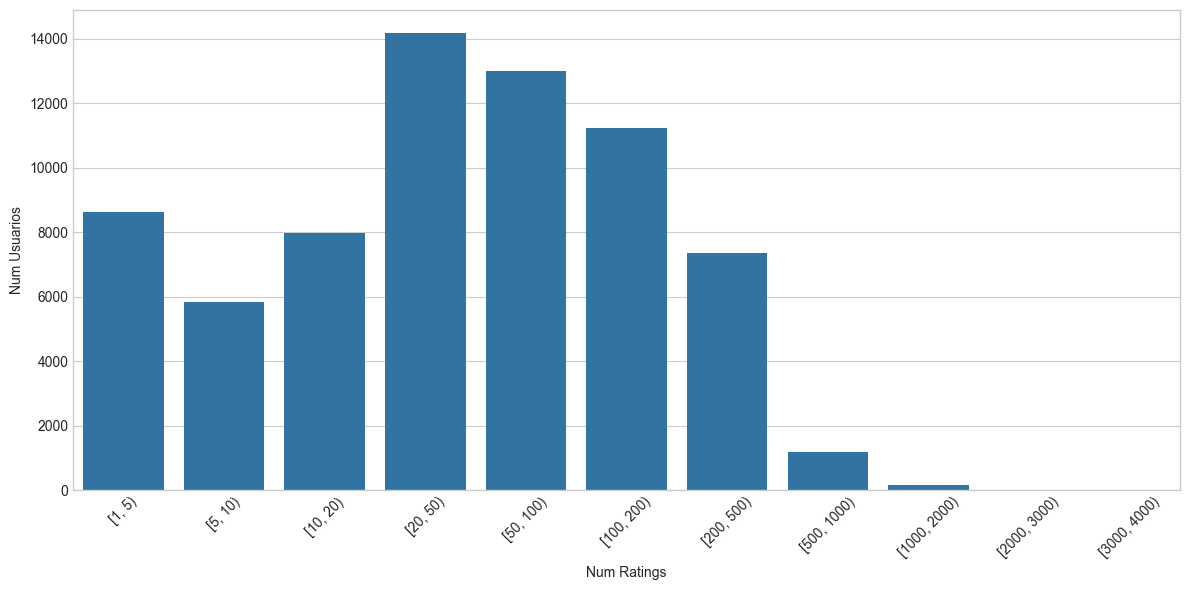

In [34]:
bins = [1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 3000, 4000]

distribucion = df_ratings['user_id'].value_counts().value_counts().sort_index()
distribucion_separada = pd.cut(distribucion.index, bins=bins, right=False)
distribucion_agrupada = distribucion.groupby(distribucion_separada).sum()

plt.figure(figsize=(12,6))
sns.barplot(x=distribucion_agrupada.index.astype(str), y=distribucion_agrupada.values)

plt.xlabel('Num Ratings')
plt.ylabel('Num Usuarios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Vamos a mantener los usuarios y animes que tienen más de 40 ratings.

In [35]:
usuarios_utiles = df_ratings['user_id'].value_counts()[df_ratings['user_id'].value_counts() > 40].index
df_ratings = df_ratings[df_ratings['user_id'].isin(usuarios_utiles)]

In [36]:
animes_utiles = df_ratings['anime_id'].value_counts()[df_ratings['anime_id'].value_counts() > 40].index
df_ratings = df_ratings[df_ratings['anime_id'].isin(animes_utiles)]

In [37]:
print(f'{df_ratings.anime_id.nunique()=}, {df_ratings.anime_id.max()=}')
print(f'{df_ratings.user_id.nunique()=}, {df_ratings.user_id.max()=}')

df_ratings.anime_id.nunique()=5413, df_ratings.anime_id.max()=np.int64(34240)
df_ratings.user_id.nunique()=36470, df_ratings.user_id.max()=np.int64(73515)


Vemos que el tamaño sigue siendo demasiado grande para entrenar en nuestros ordenadores, sobre todo para el KNN. Hemos decidido elegir una muestra de solo 1000 usuarios.

In [38]:
usuarios_unicos = df_ratings['user_id'].unique()
sampled_user_ids = np.random.choice(usuarios_unicos, size=1000, replace=False)
df_ratings = df_ratings[df_ratings['user_id'].isin(sampled_user_ids)]

In [39]:
print(f'{df_ratings.anime_id.nunique()=}, {df_ratings.anime_id.max()=}')
print(f'{df_ratings.user_id.nunique()=}, {df_ratings.user_id.max()=}')

df_ratings.anime_id.nunique()=5098, df_ratings.anime_id.max()=np.int64(34240)
df_ratings.user_id.nunique()=1000, df_ratings.user_id.max()=np.int64(73440)


In [40]:
sum(df_ratings.anime_id.value_counts() < 20)

3374

Vemos que ahora se nos han quedado muchos animes con pocas valoraciones. 
Vamos a filtrar una última vez para que estén más o menos balanceados.

In [41]:
animes_utiles = df_ratings['anime_id'].value_counts()[df_ratings['anime_id'].value_counts() > 20].index
df_ratings = df_ratings[df_ratings['anime_id'].isin(animes_utiles)]

In [42]:
df_ratings.shape

(137262, 3)

Se nos quedan casi 135k reviews, que nos parece un buen número.

In [43]:
df_ratings.anime_id.value_counts(), df_ratings.user_id.value_counts()

(anime_id
 1535     675
 16498    553
 11757    548
 1575     547
 6547     545
         ... 
 23225     21
 31389     21
 489       21
 9581      21
 1094      21
 Name: count, Length: 1674, dtype: int64,
 user_id
 5310     847
 53528    755
 5669     644
 60721    627
 16817    615
         ... 
 8954      32
 10494     32
 52514     31
 25460     22
 35464      5
 Name: count, Length: 1000, dtype: int64)

In [46]:
print(f'{df_ratings.anime_id.nunique()=}, {df_ratings.anime_id.max()=}')
print(f'{df_ratings.user_id.nunique()=}, {df_ratings.user_id.max()=}')

df_ratings.anime_id.nunique()=1674, df_ratings.anime_id.max()=np.int64(34240)
df_ratings.user_id.nunique()=1000, df_ratings.user_id.max()=np.int64(73440)


En ambos tienen por lo menos 20 reviews, nos parece un buen número.

Vemos que hay solo 1713 animes, pero que hay ids hasta el 34240, vamos a hacer un mapeado para que empiecen desde el índice 0 hasta el 1712. Con el número de usuarios hacemos lo mismo.


In [47]:
df_ratings['user_id'], user_original_ids = pd.factorize(df_ratings['user_id'])
df_ratings['anime_id'], anime_original_ids = pd.factorize(df_ratings['anime_id'])
df_ratings.reset_index(drop=True, inplace=True)

In [48]:
df_ratings

,user_id,anime_id,rating
0,0,0,7
1,0,1,7
2,0,2,7
3,0,3,8
4,0,4,7
...,...,...,...
137257,999,211,7
137258,999,138,7
137259,999,214,7
137260,999,73,10


Vamos a definir algunas constantes.

In [49]:
NUM_USERS = df_ratings['user_id'].nunique()
NUM_ANIMES = df_ratings['anime_id'].nunique()

MIN_RATING = df_ratings['rating'].min()
MAX_RATING = df_ratings['rating'].max()
SCORES = sorted(df_ratings['rating'].unique().tolist()) # Para BeMF

print(f"NUM_USERS: {NUM_USERS}")
print(f"NUM_ANIMES: {NUM_ANIMES}")
print(f"MIN_RATING: {MIN_RATING}")
print(f"MAX_RATING: {MAX_RATING}")
print(f"SCORES: {SCORES}")

NUM_USERS: 1000
NUM_ANIMES: 1674
MIN_RATING: 1
MAX_RATING: 10
SCORES: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Ahora vamos a dividir el datafram en train y test.

In [50]:
train_df, test_df = train_test_split(df_ratings,
                                     test_size=0.2,          
                                     random_state=RANDOM_STATE,    
                                     stratify=df_ratings['user_id'])
print(f"Tamaño del conjunto de entrenamiento (train_df): {len(train_df)}")
print(f"Tamaño del conjunto de prueba (test_df): {len(test_df)}")

# (Opcional pero buena práctica) Verificar si hay solapamiento y si todos los
# usuarios/ítems de test_df están de alguna forma representados en train_df.
# Con la estratificación y un tamaño de test razonable, esto es menos problemático,
# pero para estar seguros, podemos filtrar test_df para que solo contenga
# usuarios e ítems que también existen en train_df.
# Esto es más para asegurar que no intentamos evaluar sobre entidades completamente nuevas
# para las que el modelo no podría haber aprendido nada.

# Primero, obtener los IDs únicos de usuarios e ítems en el conjunto de entrenamiento
train_user_ids = train_df['user_id'].unique()
train_anime_ids = train_df['anime_id'].unique()

# Filtrar el conjunto de prueba
test_df_original_len = len(test_df)
test_df = test_df[test_df['user_id'].isin(train_user_ids)]
test_df = test_df[test_df['anime_id'].isin(train_anime_ids)]
print(f"Tamaño del conjunto de prueba (test_df) después de asegurar overlap: {len(test_df)}")
if len(test_df) < test_df_original_len:
    print(f"  Se eliminaron {test_df_original_len - len(test_df)} filas de test_df que contenían usuarios/animes no presentes en train_df.")


Tamaño del conjunto de entrenamiento (train_df): 109809
Tamaño del conjunto de prueba (test_df): 27453
Tamaño del conjunto de prueba (test_df) después de asegurar overlap: 27453


Ahora creamos las matrices de ratings

In [51]:
ratings_train_matrix = [[None for _ in range(NUM_ANIMES)] for _ in range(NUM_USERS)]
for _, row in train_df.iterrows():
    ratings_train_matrix[int(row.user_id)][int(row.anime_id)] = int(row.rating)
    
ratings_test_matrix = [[None for _ in range(NUM_ANIMES)] for _ in range(NUM_USERS)]
for _, row in test_df.iterrows():
    ratings_test_matrix[int(row.user_id)][int(row.anime_id)] = int(row.rating)

In [257]:
len(ratings_train_matrix),len(ratings_train_matrix[0]), len(ratings_train_matrix) * len(ratings_train_matrix[0])

(1000, 1713, 1713000)